# MDL Exercise 1 Semantic 3D Segmentation
The objective of this exercise is to guide you step-by-step through the implementation of a deep 3D-CNN for multi-organ segmentation. We will be using the Learn2Reg Abdominal CT dataset with 20 training and 10 validation scans each manually labelled with 13 organs.

The **exercise** is split into two basic tasks and one bonus task. First you will implement and train a standard fully-convolutional network that directly predicts the probability of each class on a coarse grid and uses a simple upsampling to match the original resolution. Second you will extend the network to learn more abstract ("deeper") features and implement two classifiers (low and high), one of them with a squeeze-and-excitation module.

The **bonus** task will focus on reducing the model complexity by replacing standard convolutions with inverted residuals from MobileNet.

In [ ]:
import os
!pip install torchinfo
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchinfo import summary
from tqdm.notebook import tqdm, trange

torch.cuda.empty_cache()

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# check if cuda and training with mixed precision is available
tensor_cores_available = False
if (torch.cuda.is_available() == False):
    print('CUDA not found! It is highly recommended to enable CUDA for the exercises')
else:
    print('CUDA GPU found: ', torch.cuda.get_device_name(['0']))
    if torch.cuda.get_device_capability('cuda')[0] >= 7:
        tensor_cores_available = True
        print('Turing/Ampere with TensorCores is available, you can speed up training with FP16 precision')

device = 'cuda' # if tensor_cores_available else 'cpu'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CUDA GPU found:  Tesla T4
Turing/Ampere with TensorCores is available, you can speed up training with FP16 precision


In [ ]:
# download data and visualise an example ground truth segmentation
!wget -nc https: // cloud.imi.uni-luebeck.de/s/ijcNnYg2yFPqpZr/download -O L2R_Task3_AbdominalCT.tar
!wget -nc https: // cloud.imi.uni-luebeck.de/s/TALoqagyYeqQFs4/download -O abdomen_labels.txt
!tar -xf L2R_Task3_AbdominalCT.tar

File ‘L2R_Task3_AbdominalCT.tar’ already there; not retrieving.
File ‘abdomen_labels.txt’ already there; not retrieving.


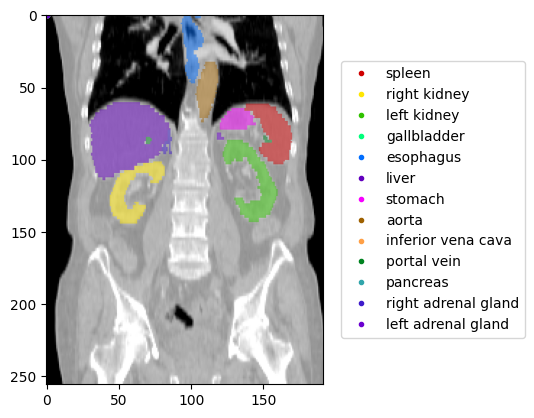

In [ ]:
# select one scan as validation example
nu = 26
img_val = torch.from_numpy(nib.load('Training/img/img00' + str(nu).zfill(2) + '.nii.gz').get_fdata()).float()
img_val = img_val.permute(2, 1, 0)
gt_val = torch.from_numpy(nib.load('Training/label/label00' + str(nu).zfill(2) + '.nii.gz').get_fdata()).float()
gt_val = gt_val.permute(2, 1, 0)
H, W, D = img_val.shape


# overlaySegment: returns RGB-overlay of given image and segmentation
@torch.no_grad()
def overlaySegment(gray1, segs1, colors):
    H, W = segs1.squeeze().size()
    C = colors.shape[0]
    segs1_onehot = torch.zeros(size=(C, H, W)).to(segs1.device).scatter_(0, segs1.view(1, H, W), 1).detach()
    seg_color = torch.mm(segs1_onehot.view(C, -1).t(), colors).view(H, W, 3)
    alpha = torch.clamp(1.0 - 0.5 * (segs1_onehot[0, :, :] == 0).float(), 0, 1.0)
    overlay = (gray1 * alpha).unsqueeze(2) + seg_color * (1.0 - alpha).unsqueeze(2)
    return overlay

# plot an example
cdata = torch.from_numpy(np.loadtxt('abdomen_labels.txt', skiprows=14, usecols=(1, 2, 3))).float()
organs = np.genfromtxt('abdomen_labels.txt', dtype='str', delimiter='"', skip_header=14, usecols=(1,))
rgb = overlaySegment(torch.clamp(img_val.flip(0).squeeze()[:, 70] + 800, 0, 1200) / 1200,
                     gt_val.flip(0).long().squeeze()[:, 70], cdata.view(-1, 3) / 255)
plt.imshow(rgb)
for i in range(1, 14):
    plt.plot(0, 0, '.', color=cdata[i].numpy() / 255, label=organs[i])
    plt.legend(bbox_to_anchor=(1.04, .5), loc='center left')
plt.show()

Provided functions for normalising CT scans and calculating Dice

In [ ]:
@torch.no_grad()
def nnUNetCTnorm(img):
    img = torch.clamp(img, -1000, 1500)
    mean_intensity = img.mean()
    std_intensity = img.std()
    lower_bound = torch.quantile(img, 0.005)
    upper_bound = torch.quantile(img, 0.995)
    img = torch.clamp(img, lower_bound, upper_bound)
    img = (img - mean_intensity) / std_intensity
    return img


img_norm_val = nnUNetCTnorm(img_val.unsqueeze(0).unsqueeze(0))

@torch.no_grad()
def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label - 1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs == label_num).view(-1).float()
        tflat = (labels == label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num - 1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice

Next, we prepare the training data and store everything in the dataset "Learn2RegAbdomenCT" with 13 organs and where the boolean `train` distinguish between the training and validation mode.

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class Learn2RegAbdomenCT(Dataset):
    def __init__(self, train=True):
        self.train = train
        if train:
            cases = (2, 3, 5, 6, 8, 9, 21, 22, 24, 25, 27, 28, 30, 31, 33, 34, 36, 37, 39, 40)
        else:
            cases = (1, 4, 7, 10, 23, 26, 29, 32, 35, 38)
        self.img_norm = torch.empty(len(cases), 1, 256, 160, 192)
        self.gt_label = torch.empty(len(cases), 256, 160, 192, dtype=torch.long)
        for i, nu in enumerate(tqdm(cases, desc='loading data')):
            img = torch.from_numpy(nib.load('Training/img/img00' + str(nu).zfill(2) + '.nii.gz').get_fdata()).float()
            img = img.permute(2, 1, 0)
            gt = torch.from_numpy(nib.load('Training/label/label00' + str(nu).zfill(2) + '.nii.gz').get_fdata()).long()
            gt = gt.permute(2, 1, 0)
            img_norm = nnUNetCTnorm(img.unsqueeze(0).unsqueeze(0)).squeeze()
            self.img_norm[i, 0] = img_norm
            self.gt_label[i] = gt

    def __len__(self):
        return len(self.img_norm)

    def __getitem__(self, idx):
        image = self.img_norm[idx]
        label = self.gt_label[idx]

        return image, label


# create instances of dataset and training dataloader
train_dataset = Learn2RegAbdomenCT(train=True)

train_img, train_label = train_dataset[0]
print('Shapes of each img/label tensor pair', train_img.shape, train_label.shape)

loading data:   0%|          | 0/20 [00:00<?, ?it/s]

Shapes of each img/label tensor pair torch.Size([1, 256, 160, 192]) torch.Size([256, 160, 192])


# Task: Affine transformation (15 points)

Due to the lack of training data in our dataset and thus the high risk of overfitting during training, we want to create synthetic data by using small random affine transformations on the fly.

Therefor, we use `F.grid_sample` that takes a grid (flow field) with world coordinates and samples the values from the input for the specified position. Read the [pytorch-doc](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) for a detailed explanation.

Let's create a grid with `F.affine_grid`. Therefor, we need a random transformation matrix `theta` of shape $[B, 3, 4]$, where $B$ describes the batch size. Create `theta` using `torch.eye` and add a random offset via `torch.randn` to it. The offset should be weighted with 0.05 (Hint: to obtain the needed shape use broadcasting with `.unsqueeze(0)` on the eye matrix). Next, we use `theta` to create the flow filed with `F.affine_grid` with the image shape as target output size.

Now, we just sample from our image and ground truth via `F.grid_sample` with `padding_mode=border`. Use `mode=bilinear` for the image and `mode=nearest` for the ground truth. We also have to consider the datatype of `ground_truth` and add a channel dimension to it with `.unsqueeze(1)`.

If you like, you can also perform the augmentation on the GPU (do not forget `with torch.no_grad()` or the decorator `@torch.no_grad`).

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


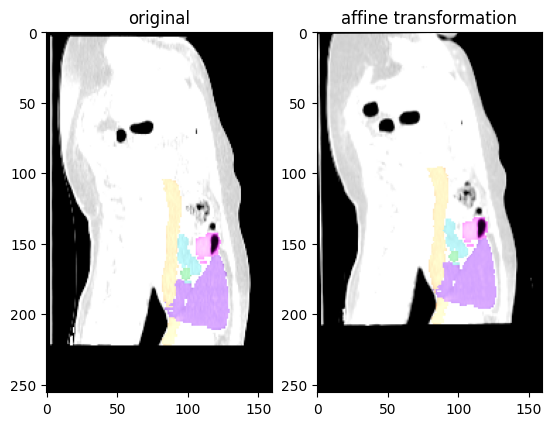

In [ ]:
@torch.no_grad()
def augment_affine(image: torch.Tensor, ground_truth: torch.Tensor):
    batch_size = image.shape[0]
    # todo: implement the affine transformation

    theta = torch.eye(3, 4).unsqueeze(0) + (torch.randn((batch_size, 3, 4)) * 0.05)
    theta.to(device)
    grid = F.affine_grid(theta, size = image.size()).to(device)
    
    image =  F.grid_sample(image, grid, mode='bilinear', padding_mode='border')
    ground_truth = ground_truth.to(torch.float).unsqueeze(1)
    ground_truth =  F.grid_sample(ground_truth, grid, mode='nearest', padding_mode='border').to(torch.long)

    # need to be fulfilled
    assert image.dtype == torch.float
    assert ground_truth.dtype == torch.long
    assert list(image.shape) == [batch_size, 1, 256, 160, 192]
    assert list(ground_truth.shape) == [batch_size, 1, 256, 160, 192]

    return image, ground_truth.squeeze()


# provided function to visualize augmentation
img, gt = train_dataset[0]
idx = 95

fig, axs = plt.subplots(1, 2)
rgb = overlaySegment(img.squeeze()[:, :, idx], gt[:, :, idx].long(), cdata.view(-1, 3) / 255)
axs[0].imshow(rgb)
axs[0].set_title('original')

img, gt = augment_affine(img.unsqueeze(0).to(device), gt.unsqueeze(0).to(device))
rgb_aug = overlaySegment(img.squeeze()[:, :, idx].cpu(), gt[:, :, idx].cpu(), cdata.view(-1, 3) / 255)
axs[1].imshow(rgb_aug)
axs[1].set_title('affine transformation');

# Task 1.1 (15 points)
The different organs in 3D medical images are very different in size, while the liver has a volume of 1.5-2 litres (and several hundred thousands of voxels) the adrenial glands are only of a few millilitres with a few thousands voxels. We therefore need to weigh the loss with inverse frequency to improve the training stability. You can use ```torch.bincount```([pytorch-doc](https://pytorch.org/docs/stable/generated/torch.bincount.html)) on a 1D vector (of long datatype) that you can obtain from ```train_dataset.gt_label```. Convert the count into a float vector and use a reciprocal power of 0.35 to obtain a **weight** vector. Divide this vector by its mean - it should look as follows:
```[0.0873, 0.5060, 0.6909, 0.6879, 1.2039, 1.5785, 0.2965, 0.4819, 0.8316, 0.8406, 1.1448, 0.8602, 2.4897, 2.3003]```

In [ ]:
#TODO weighted CE-Loss 
a = train_dataset.gt_label.flatten()
weight = torch.bincount(a).to(torch.float) ** -0.35
weight = weight / weight.mean()
print(weight)

tensor([0.0873, 0.5060, 0.6909, 0.6879, 1.2039, 1.5785, 0.2965, 0.4819, 0.8316,
        0.8406, 1.1448, 0.8602, 2.4897, 2.3003])


Next, we build our fully-convolutional network `fullyconv` that directly predicts the probability of each class on a coarse grid and uses a simple upsampling to match the original resolution. Therefor, we need a `nn.Sequential` container that holds four ConvGroups. Each group consists of 
1. a `nn.Conv3d` with kernel size = 3, padding = 1 and no bias
1. a `nn.InstanceNorm3d` for normalisation
1. a `nn.LeakyReLU` as non-linearity

The first ConvGroup should increase the channel dimension to 16 and reduce the spatial dimension with a stride=2 in the `nn.Conv3d`. The second group should double the channels and again reduce the spatial dimension using the same stride as group one. The third and fourth group have an output channel dimension=64 and keep the spatial resolution (no stride).

Finally, we use a single `nn.Conv3d` with same kernel and padding properties like the one of the ConvGroup, but this time with the bias enabled, as classifier. The output channel should match the number of classes=14 (13 organs and one "residues" class).

The Model should hold about $204\,350$ trainable parameters.

In [ ]:
# for reproducibility
torch.manual_seed(42)

class fullyconv(nn.Module):
  def __init__(self):
    super(fullyconv, self).__init__()
  
#TODO implement backbone
    self.ConvGroup1 =  nn.Sequential(
        nn.Conv3d(in_channels=1, out_channels=16, stride = 2, kernel_size = 3, padding= 1, bias=False),
        nn.InstanceNorm3d(16),
        nn.LeakyReLU(),

        nn.Conv3d(in_channels= 16, out_channels=32, stride = 2, kernel_size = 3, padding= 1, bias=False),
        nn.InstanceNorm3d(32),
        nn.LeakyReLU(),

        nn.Conv3d(in_channels=32, out_channels=64, stride = 1 , kernel_size = 3, padding= 1, bias=False),
        nn.InstanceNorm3d(64),
        nn.LeakyReLU(),
  
        nn.Conv3d(in_channels=64, out_channels=64, stride = 1 , kernel_size = 3, padding= 1, bias=False),
        nn.InstanceNorm3d(64),
        nn.LeakyReLU(),
        
        nn.Conv3d(in_channels=64, out_channels=14, kernel_size = 3, padding= 1, bias=True)
    )
    
  def forward(self, x):
    x = self.ConvGroup1(x)
    return x

summary(fullyconv().to('cuda'), (1, 1, 256, 160, 192))

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
fullyconv                                [1, 14, 64, 40, 48]       --
├─Sequential: 1-1                        [1, 14, 64, 40, 48]       --
│    └─Conv3d: 2-1                       [1, 16, 128, 80, 96]      432
│    └─InstanceNorm3d: 2-2               [1, 16, 128, 80, 96]      --
│    └─LeakyReLU: 2-3                    [1, 16, 128, 80, 96]      --
│    └─Conv3d: 2-4                       [1, 32, 64, 40, 48]       13,824
│    └─InstanceNorm3d: 2-5               [1, 32, 64, 40, 48]       --
│    └─LeakyReLU: 2-6                    [1, 32, 64, 40, 48]       --
│    └─Conv3d: 2-7                       [1, 64, 64, 40, 48]       55,296
│    └─InstanceNorm3d: 2-8               [1, 64, 64, 40, 48]       --
│    └─LeakyReLU: 2-9                    [1, 64, 64, 40, 48]       --
│    └─Conv3d: 2-10                      [1, 64, 64, 40, 48]       110,592
│    └─InstanceNorm3d: 2-11              [1, 64, 64, 40, 48]       --
│

# Task 1.2 (40 points)
**Implement your training loop** by completing the function `train_model` with the forward and backward pass, the update step on the optimizer and returns the loss history. Refer to [torch.optim](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step) to see an example of the training loop in pytorch.
In case you want to explore accelerated FP16 training have a look at [cuda.amp.autocast](https://pytorch.org/docs/stable/notes/amp_examples.html).

Each training step will be on a batch of three images. Move the images and labels to the GPU and augment them with your `augment_affine` function. Make sure to upsample the prediction of your model to the correct output shape (same size as your target) using ```F.interpolate``` [pytorch-doc](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html). Do not forget to pass the **weight** tensor to ```nn.CrossEntropyLoss```[pytorch-doc](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

The training takes about 4 minutes on a Tesla T4 GPU and should result in an average validation Dice of approx. 35%


In [ ]:
# instantiate dataset for validation and dataloader for the training dataset
val_dataset = Learn2RegAbdomenCT(train=False)
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=3, drop_last=True)

loading data:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# TODO: implement training loop

def train_model(model: nn.Module):
  num_epoch = 100
  loss_history = [] # torch.zeros(num_epoch)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
  criterion = nn.CrossEntropyLoss(weight = weight.to('cuda'))

  for epoch in trange(num_epoch, unit='epochs'):
    #model = model
    epoch_loss = 0
    model.train()

    for img, lbl in train_dataloader:
        # TODO
        img = img.to('cuda')
        lbl = lbl.to('cuda')
        img, lbl = augment_affine(img, lbl)

        logits = model(img)
        logits = F.interpolate(logits, size=(256, 160, 192), mode='trilinear')
        loss = criterion(logits, lbl)

        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss /= len(train_dataloader)
    loss_history.append(epoch_loss)   
    # loss_history /= len(train_dataloader) * train_dataloader.batch_size
    
    ### VALIDATION ###
    if True: #epoch % 5 == 4:
      model.eval()
      dice = torch.zeros(13)
      for x, y in val_dataset:
        x = x.cuda(non_blocking=True).unsqueeze(0)
        y = y.cuda(non_blocking=True)
        with torch.no_grad():
              y_hat = model(x)
              y_hat = F.interpolate(y_hat, size=(H, W, D), mode='trilinear', align_corners=True)
              dice += dice_coeff(y_hat.argmax(1).squeeze(), y, 14)
      dice /= len(val_dataset)
      tqdm.write(f"{epoch} epoch: loss: {'%0.3f'%loss_history[epoch]}, Dice: {'%0.3f'%(100*dice.mean())}")
    
  return loss_history

model = fullyconv().to('cuda')
run_loss = train_model(model)

  0%|          | 0/100 [00:00<?, ?epochs/s]

0 epoch: loss: 1.281, Dice: 0.000
1 epoch: loss: 0.865, Dice: 0.000
2 epoch: loss: 0.779, Dice: 2.618
3 epoch: loss: 0.760, Dice: 1.691
4 epoch: loss: 0.746, Dice: 2.408
5 epoch: loss: 0.748, Dice: 0.877
6 epoch: loss: 0.718, Dice: 0.453
7 epoch: loss: 0.688, Dice: 1.535
8 epoch: loss: 0.703, Dice: 1.719
9 epoch: loss: 0.674, Dice: 3.078
10 epoch: loss: 0.671, Dice: 4.453
11 epoch: loss: 0.616, Dice: 4.368
12 epoch: loss: 0.626, Dice: 5.662
13 epoch: loss: 0.630, Dice: 5.831
14 epoch: loss: 0.571, Dice: 7.014
15 epoch: loss: 0.602, Dice: 8.387
16 epoch: loss: 0.583, Dice: 8.898
17 epoch: loss: 0.564, Dice: 9.661
18 epoch: loss: 0.561, Dice: 11.049
19 epoch: loss: 0.576, Dice: 10.366
20 epoch: loss: 0.632, Dice: 7.363
21 epoch: loss: 0.617, Dice: 11.247
22 epoch: loss: 0.513, Dice: 12.498
23 epoch: loss: 0.510, Dice: 14.839
24 epoch: loss: 0.482, Dice: 15.378
25 epoch: loss: 0.518, Dice: 13.847
26 epoch: loss: 0.448, Dice: 15.320
27 epoch: loss: 0.510, Dice: 15.781
28 epoch: loss: 0.472

We have provided a function that visualises the outcome on an unseen scan after the training has finished

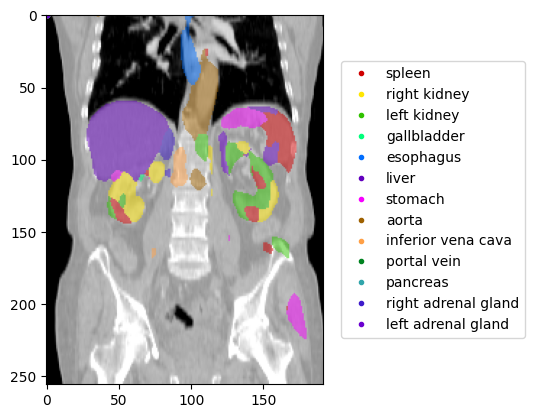

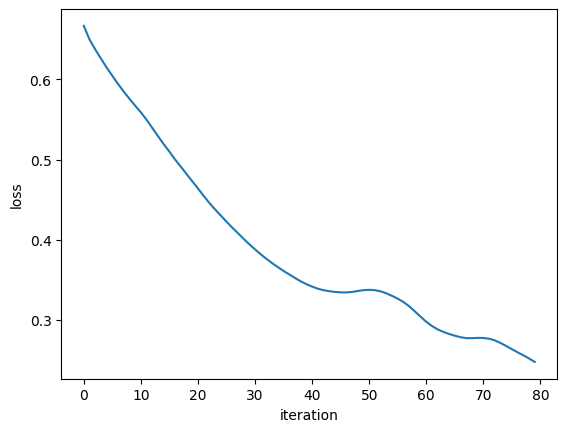

In [ ]:
def show_results(model, val_image, training_loss):
    y_hat = F.interpolate(model(val_image.cuda()), size=img_norm_val.shape[-3:], mode='trilinear', align_corners=True).argmax(1).cpu()
    rgb = overlaySegment(torch.clamp(img_val.flip(0).squeeze().cpu()[:,70]+800,0,1200)/1200,y_hat.squeeze().flip(0).long()[:,70],cdata.view(-1,3)/255)
    plt.imshow(rgb)
    for i in range(1,14):
        plt.plot(0,0,'.',color=cdata[i].numpy()/255,label=organs[i])
        plt.legend(bbox_to_anchor=(1.04,.5), loc='center left' )
    plt.show()

    plt.plot(F.avg_pool1d(F.avg_pool1d(training_loss.view(1,1,-1),11,stride=1),11,stride=1).squeeze())
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()

# cast run_loss to tensor, because list does not allow plot
show_results(model.to('cuda'), img_norm_val, torch.Tensor(run_loss))

In [ ]:
fullyconv = fullyconv().cpu()
torch.cuda.empty_cache()

# Task 2 (30 points)
We can see that this simple model produces only moderately accurate segmentations. We therefore want to implement an advanced segmentation network known as **lite reduced atrous spatial pyramid pooling (LR-ASPP)** [Paper: Searching for MobileNet V3](https://arxiv.org/pdf/1905.02244v1.pdf), which basically consists of two classifiers: one with a high number of channel and low spatial resolution and one with a lower number of channels and higher spatial resolution.
![LRASPP_fig](https://github.com/mattiaspaul/binder_test/raw/main/architecture.png)
To obtain the *deeper* features with more channels we need another sequential container with two groups of `nn.Conv3d`, `nn.InstanceNorm3d` and `nn.ReLU`. This sequential container is denoted as **high**. It takes 64 feature maps as an input and double this number twice while reducing spatial dimensions by 2. Increasing number of channels and reduction of spatial dimensions is done by the first `nn.Conv3d` of this sequential block.

Features of the **high** sequential container is used as input for a squeeze-and-exication block (denoted as SAE) that comprises `nn.AdaptiveAvgPool3d` another `nn.Conv3d` (with kernel size = 1) and `nn.Sigmoid` as activation. This produces a global channel weights that are multiplied to the result of the CBR block comprising `nn.Conv3d`, `nn.InstanceNorm3d` and `nn.LeakyReLU`.

Finally, the product has to be upsampled by a factor of 2 and the number of channels needs to be projected to 14 output channels using a `nn.Conv3d` (with kernel size = 1) as classifier HIGH.

For the low-channel path `nn.Conv3d` (kernel=3, in_channel=out_channel), `nn.InstanceNorm3d`, `nn.LeakyReLU`, `nn.Conv3d` (kernel=1) block will be used that produces 14 output channels (classifier LOW).

Finally results of HIGH and LOW classifiers are simply added.

The training time should remain similar, but the accuracy can be improved up to ~50% Dice.

In [ ]:
#TODO: implement LRASPP architecture
class LRASPP(nn.Module):
    def __init__(self, high_channels=256, inter_channels=128, low_channels=64, num_classes=14):
        super().__init__()
        # todo - irgendwas mit den dimensionen stimmt hier noch nicht
        self.net_low = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride = 2, padding= 1, bias=False),
            nn.InstanceNorm3d(16),
            nn.LeakyReLU(),

            nn.Conv3d(in_channels= 16, out_channels=32, kernel_size=3, stride = 2, padding= 1, bias=False),
            nn.InstanceNorm3d(32),
            nn.LeakyReLU(),

            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride = 1, padding= 1, bias=False),
            nn.InstanceNorm3d(64),
            nn.LeakyReLU(),
      
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride = 1, padding= 1, bias=False),
            nn.InstanceNorm3d(64),
            nn.LeakyReLU()
            )
        
        self.net_high = nn.Sequential(
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2),
            nn.InstanceNorm3d(128),
            nn.ReLU(),

            nn.Conv3d(in_channels=128, out_channels=256, padding=1, kernel_size=3),
            nn.InstanceNorm3d(256),
            nn.ReLU()
            )

        self.SAE = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d (in_channels=256, out_channels=128, kernel_size=1),
            nn.Sigmoid(),
            )
                
        self.CBR = nn.Sequential(
            nn.Conv3d(in_channels=256, out_channels=128, kernel_size=1),
            nn.InstanceNorm3d(128),
            nn.LeakyReLU(),
        )

        self.LOW = nn.Sequential(
            nn.Conv3d (in_channels=64, out_channels=64, kernel_size=3),
            nn.InstanceNorm3d(64),
            nn.LeakyReLU(),
            nn.Conv3d(in_channels=64, out_channels=14, kernel_size=1, padding=1)
            )

        self.HIGH = nn.Conv3d(in_channels=128, out_channels=14, kernel_size=1)

    def forward(self, input):
      out_low  = self.net_low(input)
      out_LOW = self.LOW(out_low)
      out_high = self.net_high(out_low)

      out_sae = self.SAE(out_high)
      out_cbr = self.CBR(out_high)
      out_high_class = self.HIGH(F.interpolate((out_cbr * out_sae), scale_factor=2))

      out = out_LOW + out_high_class
      return out


lraspp = LRASPP()
lraspp.cuda()
summary(lraspp.cuda(), (1, 1, 256, 160, 192))

Layer (type:depth-idx)                   Output Shape              Param #
LRASPP                                   [1, 14, 64, 40, 48]       --
├─Sequential: 1-1                        [1, 64, 64, 40, 48]       --
│    └─Conv3d: 2-1                       [1, 16, 128, 80, 96]      432
│    └─InstanceNorm3d: 2-2               [1, 16, 128, 80, 96]      --
│    └─LeakyReLU: 2-3                    [1, 16, 128, 80, 96]      --
│    └─Conv3d: 2-4                       [1, 32, 64, 40, 48]       13,824
│    └─InstanceNorm3d: 2-5               [1, 32, 64, 40, 48]       --
│    └─LeakyReLU: 2-6                    [1, 32, 64, 40, 48]       --
│    └─Conv3d: 2-7                       [1, 64, 64, 40, 48]       55,296
│    └─InstanceNorm3d: 2-8               [1, 64, 64, 40, 48]       --
│    └─LeakyReLU: 2-9                    [1, 64, 64, 40, 48]       --
│    └─Conv3d: 2-10                      [1, 64, 64, 40, 48]       110,592
│    └─InstanceNorm3d: 2-11              [1, 64, 64, 40, 48]       --
│

In [ ]:
# re-use the same training loop as before
run_loss = train_model(model=lraspp)

  0%|          | 0/100 [00:00<?, ?epochs/s]

0 epoch: loss: 2.045, Dice: 2.265
1 epoch: loss: 1.037, Dice: 1.979
2 epoch: loss: 0.800, Dice: 4.152
3 epoch: loss: 0.686, Dice: 4.945
4 epoch: loss: 0.653, Dice: 4.034
5 epoch: loss: 0.582, Dice: 4.932
6 epoch: loss: 0.585, Dice: 5.005
7 epoch: loss: 0.571, Dice: 5.480
8 epoch: loss: 0.550, Dice: 5.756
9 epoch: loss: 0.541, Dice: 6.032
10 epoch: loss: 0.528, Dice: 10.954
11 epoch: loss: 0.458, Dice: 14.316
12 epoch: loss: 0.495, Dice: 16.241
13 epoch: loss: 0.454, Dice: 15.148
14 epoch: loss: 0.452, Dice: 18.882
15 epoch: loss: 0.384, Dice: 23.615
16 epoch: loss: 0.361, Dice: 26.657
17 epoch: loss: 0.357, Dice: 25.691
18 epoch: loss: 0.365, Dice: 26.486
19 epoch: loss: 0.358, Dice: 29.758
20 epoch: loss: 0.359, Dice: 19.902
21 epoch: loss: 0.430, Dice: 21.745
22 epoch: loss: 0.412, Dice: 24.094
23 epoch: loss: 0.365, Dice: 23.481
24 epoch: loss: 0.319, Dice: 27.024
25 epoch: loss: 0.292, Dice: 27.836
26 epoch: loss: 0.316, Dice: 28.679
27 epoch: loss: 0.317, Dice: 31.095
28 epoch: lo

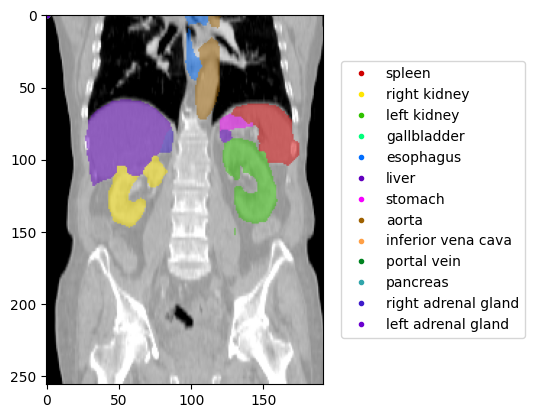

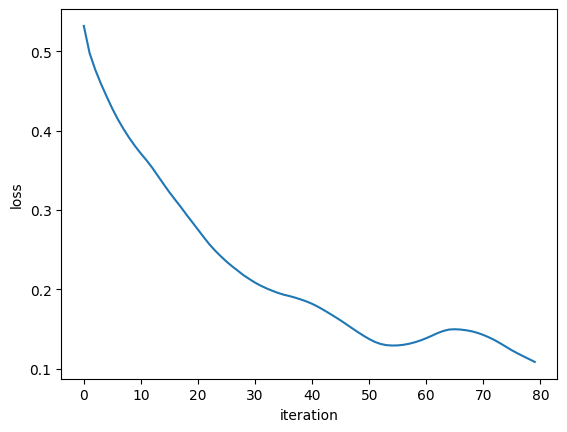

In [ ]:
# re-use results visualization method
show_results(lraspp, img_norm_val, torch.Tensor(run_loss))

In [ ]:
# free GPU memory
lraspp = lraspp.cpu()
torch.cuda.empty_cache()

# Bonus Task (10 bonus points)
While the LRASPP model with standard 3D convolutions yields excellent results, its feature extractors also require a large amount of trainable parameters. In the bonus task you should implement the depth-seperable convolution blocks (denoted as *inverted*) of MobileNet V3.

Depth-seperable convolution blocks consist of two convolutions with kernel size = 1 and an intermediate convolution with kernel = 3 but groups=#channels. That means the number of parameters and computations is drastically reduced. When increasing the intermediate channel width (to about twice the number of output channels) the capacity of representing complex feature transformations is maintained.

In [ ]:
# TODO: implement depth-separable convolution block
def inverted(in_channels,mid_channels,out_channels,stride=1):
    layer =
    return layer

# instantiate LRASPP model and substitute convolution blocks with depth-separable convolution blocks
lraspp = LRASPP()
lraspp.net_low = nn.Sequential(
    nn.Conv3d(1,16,3,padding=1,bias=False,stride=2),
    nn.InstanceNorm3d(16),
    nn.LeakyReLU(),
    inverted(16,64,32,2),
    inverted(32,128,64,1),
    inverted(64,196,64,1))
lraspp.net_high = nn.Sequential(inverted(64,256,128,2),inverted(128,256,256,1))
lraspp.CBR = inverted(256,256,128,1)

lraspp.cuda()
summary(lraspp, (1, 1, 256, 160, 192))

SyntaxError: ignored

In [ ]:
# re-use the same training loop as before
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=3, drop_last=True)
run_loss = train_model(model=lraspp)

In [ ]:
# re-use results visualization method
show_results(lraspp, img_norm_val, run_loss)

In [ ]:
# clean GPU memory
lraspp = lraspp.cpu()
torch.cuda.empty_cache()